<h1>Data preprocessing</h1>

In [33]:
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer
np.random.seed(42)
pd.set_option('display.max_columns', None)
df = pd.read_csv('dataset v1.csv')

#Convert remaining_lease into numerical remaining_lease_years
def convert_lease_to_years(lease_str):
    if not isinstance(lease_str, str):
        return np.nan
    years = 0
    months = 0
    # Use regex to find numbers associated with 'year' and 'month'
    year_match = re.search(r'(\d+)\s*year', lease_str)
    month_match = re.search(r'(\d+)\s*month', lease_str)
    if year_match:
        years = int(year_match.group(1))
    if month_match:
        months = int(month_match.group(1))
    # Return the total lease in years, or NaN if no parts were found
    if years == 0 and months == 0:
        return np.nan
    return years + months / 12.0

df['remaining_lease_years'] = df['remaining_lease'].apply(convert_lease_to_years)

#Ordinally encoded storey_range by taking the in-between storeys (floors 01-03 becomes 2)
floor_map = {'01 TO 03': 2,'04 TO 06': 5,'07 TO 09': 8,'10 TO 12': 11,'13 TO 15': 14,
    '16 TO 18': 17,'19 TO 21': 20,'22 TO 24': 23,'25 TO 27': 26,'28 TO 30': 29,
    '31 TO 33': 32,'34 TO 36': 35,'37 TO 39': 38,'40 TO 42': 41,'43 TO 45': 44,
    '46 TO 48': 47,'49 TO 51': 50,}

df['storey_ordinal'] = df['storey_range'].map(floor_map)

#Create train test splits
df.drop(columns=['Unnamed: 0','storey_range','street_name','remaining_lease','latitude','longitude','nearest_bus_stop','nearest_pei',
                   'nearest_jc','nearest_kindergarten','nearest_primary_school','nearest_secondary_school','nearest_poly',
                   'nearest_library','nearest_hospital','nearest_mall','nearest_mrt_station','nearest_sports_facility','nearest_hawker_centre'],inplace=True)
X = df.drop(columns=['resale_price'])
y = df['resale_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


# Sampling using Sample Weights
X_train['combined_feature'] = X_train['town'].astype(str) + '_' + \
                            X_train['flat_type'].astype(str) + '_' + \
                            X_train['flat_model'].astype(str)

sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=X_train['combined_feature']  # The imbalanced feature we want to correct for
)

fit_params = {
    'regressor__sample_weight': sample_weights
}
X_train.drop(columns=['combined_feature'],inplace=True)

#One hot encode categorical columns and scale numerical columns by fit transforming on train data and transforming test data
categorical_columns = ['town', 'flat_type', 'flat_model']
numerical_columns = [
    'floor_area_sqm', 'lease_commence_date',
    'dist_bus_stop_m', 'dist_pei_m', 'dist_jc_m', 'dist_kindergarten_m',
    'dist_primary_school_m', 'dist_secondary_school_m', 'dist_poly_m',
    'dist_library_m', 'dist_mall_m', 'dist_hospital_m', 'dist_mrt_station_m',
    'dist_sports_facility_m', 'dist_hawker_centre_m',
    'remaining_lease_years','storey_ordinal',]


numerical_columns = [col for col in numerical_columns if col in X_train.columns]
categorical_columns = [col for col in categorical_columns if col in X_train.columns]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_columns)
    ],
    remainder='drop'
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

#Scale y_train and y_test
scaler = QuantileTransformer(output_distribution='normal')
y_train_reshaped = y_train.values.reshape(-1, 1)
y_train_scaled = scaler.fit_transform(y_train_reshaped)

y_test_reshaped = y_test.values.reshape(-1, 1)
y_test_scaled = scaler.transform(y_test_reshaped)

In [34]:
import joblib

joblib.dump(preprocessor, 'preprocessor.joblib')
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [22]:
X_test

,month,town,flat_type,block,floor_area_sqm,flat_model,lease_commence_date,dist_bus_stop_m,dist_pei_m,dist_jc_m,dist_kindergarten_m,dist_primary_school_m,dist_secondary_school_m,dist_poly_m,dist_library_m,dist_mall_m,dist_hospital_m,dist_mrt_station_m,dist_sports_facility_m,dist_hawker_centre_m,remaining_lease_years,storey_ordinal
45989,2019-03,SEMBAWANG,3 ROOM,590B,68.0,Model A,2015,0.000000,1526.499415,2889.824656,715.156059,567.418301,1254.221504,4697.027627,867.166350,788.903607,3126.413045,788.903607,519.551556,519.552029,95.083333,17
130983,2022-02,PUNGGOL,5 ROOM,128A,110.0,Improved,2003,363.271918,389.569574,3334.168613,516.447395,327.044890,388.585274,5618.742278,1923.431513,1894.677786,2143.557331,1894.677786,2970.327588,1873.446478,80.500000,17
119961,2022-07,BUKIT BATOK,3 ROOM,182,67.0,New Generation,1984,125.201659,715.251432,3871.975509,108.999596,430.632687,302.435482,3585.978211,761.451410,746.101718,484.405091,746.101718,479.412000,714.535129,61.500000,11
21429,2018-01,TOA PAYOH,5 ROOM,138B,113.0,DBSS,2012,52.018129,399.496219,1103.808546,257.861801,207.129244,497.353295,4631.149783,662.519970,445.193398,1085.306878,445.193398,131.990223,227.374710,93.333333,11
29485,2018-06,QUEENSTOWN,3 ROOM,153,67.0,Improved,1970,43.783644,479.205235,2226.970336,283.301708,528.729262,720.037369,3499.078293,605.633926,336.848040,983.202670,336.848040,342.307112,69.359166,50.583333,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61502,2019-11,PUNGGOL,4 ROOM,270B,93.0,Premium Apartment,2013,149.555678,2099.595508,4543.770127,148.636035,249.929282,439.161092,6339.883040,909.360865,1435.524414,1203.556244,1435.524414,1759.109993,855.356119,92.166667,2
106654,2021-08,YISHUN,5 ROOM,787,121.0,Improved,1988,113.755748,646.476172,424.289645,539.411961,455.560771,215.917951,5138.165042,1050.874523,418.774514,678.739053,418.774514,382.265668,1142.968516,65.666667,8
2904,2017-03,HOUGANG,3 ROOM,523,74.0,Model A,1986,115.605640,1500.833668,1047.517155,309.179557,155.965425,199.515291,4722.397712,364.202636,414.298979,1123.231512,414.298979,456.399165,882.456105,68.666667,2
54204,2019-07,TOA PAYOH,3 ROOM,195,66.0,Improved,1973,246.192581,537.647413,668.625097,183.729412,765.983703,674.156951,5421.810727,910.648629,1200.274474,1513.138190,1200.274474,656.670304,608.336822,53.000000,8


<h1>Modelling</h1>

In [7]:
import tensorflow as tf
from tensorflow import keras
import subprocess
import sys
try:
    from scikeras.wrappers import KerasRegressor
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scikeras"])
    from scikeras.wrappers import KerasRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
from tensorflow.keras.callbacks import ReduceLROnPlateau
tf.random.set_seed(42)
np.random.seed(42)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

<h2>K-Nearest Neighbors (KNN) Regressor</h2>

In [5]:
print("--- Tuning K-Nearest Neighbors (KNN) Regressor ---")
n_neighbors_list = [10]
weights_list = ['distance']
metric_list = ['euclidean']

# Variables to store the best results
best_rmse = float('inf')
best_params = {}
results = []


# --- Manual Grid Search Loop ---
for n in n_neighbors_list:
    for w in weights_list:
        for m in metric_list:
            start_time = time.time()
            # 1. Create the KNN model with the current combination of hyperparameters
            knn_model = KNeighborsRegressor(n_neighbors=n, weights=w, metric=m, n_jobs=-1)
            knn_model.fit(X_train_processed,y_train_scaled)
            
            y_pred_scaled = knn_model.predict(X_test_processed)
            y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            current_params = {'n_neighbors': n, 'weights': w, 'metric': m}
            print(f"current_params:{current_params}")
            print(f"\nTuned KNN RMSE on Test Set: {rmse:.4f}\n")
            
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = current_params

            end_time = time.time()
            print(f"\nManual search took: {end_time - start_time:.2f} seconds")

# Train the final best model on the entire training set
final_knn_model = KNeighborsRegressor(**best_params, n_jobs=-1)
final_knn_model.fit(X_train_processed, y_train_scaled)

y_pred_scaled = final_knn_model.predict(X_test_processed)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
final_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"\nTuned KNN RMSE on Test Set: {final_test_rmse:.4f}\n")

--- Tuning K-Nearest Neighbors (KNN) Regressor ---


C:\Users\Troyk\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Troyk\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Troyk\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Troyk\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Troyk\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

current_params:{'n_neighbors': 10, 'weights': 'distance', 'metric': 'euclidean'}

Tuned KNN RMSE on Test Set: 54006.7218


Manual search took: 23.49 seconds

Tuned KNN RMSE on Test Set: 54006.7218



In [20]:
new_column_names = preprocessor.get_feature_names_out()
X_train_processed_df = pd.DataFrame(X_train_processed, columns=new_column_names)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=new_column_names)

sample_to_explain_index = 0
sample_features_df = X_test_processed_df.iloc[[sample_to_explain_index]]

# 2. Find its neighbors using the original NumPy array data
distances, indices = final_knn_model.kneighbors(sample_features_df.values)
neighbor_indices = indices[0]

# 3. Retrieve the neighbors' data using the NEW DataFrame for readability
neighbor_df = X_train_processed_df.iloc[neighbor_indices]

# Add the distance and original target values for a complete picture
neighbor_df['distance_to_sample'] = distances[0]
neighbor_df['original_target_value'] = scaler.inverse_transform(
    y_train_scaled[neighbor_indices].reshape(-1, 1)
).flatten()


# --- 4. Display the explanation ---
print("--- KNN Explanation with Readable Features ---")

# Get the model's prediction
prediction_scaled = final_knn_model.predict(sample_features_df.values)
prediction_original = scaler.inverse_transform(prediction_scaled.reshape(-1, 1)).flatten()[0]
print(f"\n🔮 Model's Prediction (Original Scale): {prediction_original:.4f}")

# Display the sample we are explaining
print("\n🔍 Features of the Sample Being Explained:")
print(sample_features_df.T) # .T transposes for easier reading

# Display the neighbors that were used
print("\n📊 The 10 Neighbors Used for This Prediction:")
print(neighbor_df)

--- KNN Explanation with Readable Features ---

🔮 Model's Prediction (Original Scale): 320000.0000

🔍 Features of the Sample Being Explained:
                                               0
num__floor_area_sqm                    -1.212303
num__lease_commence_date                1.350276
num__dist_bus_stop_m                   -0.816962
num__dist_pei_m                         0.730289
num__dist_jc_m                          0.417085
num__dist_kindergarten_m                2.346976
num__dist_primary_school_m              0.605077
num__dist_secondary_school_m            2.302301
num__dist_poly_m                        0.190659
num__dist_library_m                    -0.519395
num__dist_mall_m                       -0.078256
num__dist_hospital_m                    0.878688
num__dist_mrt_station_m                -0.078256
num__dist_sports_facility_m            -0.888845
num__dist_hawker_centre_m              -0.426231
num__remaining_lease_years              1.465961
num__storey_ordinal      

C:\Users\Troyk\AppData\Local\Temp\ipykernel_9908\2894547531.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neighbor_df['distance_to_sample'] = distances[0]
C:\Users\Troyk\AppData\Local\Temp\ipykernel_9908\2894547531.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neighbor_df['original_target_value'] = scaler.inverse_transform(


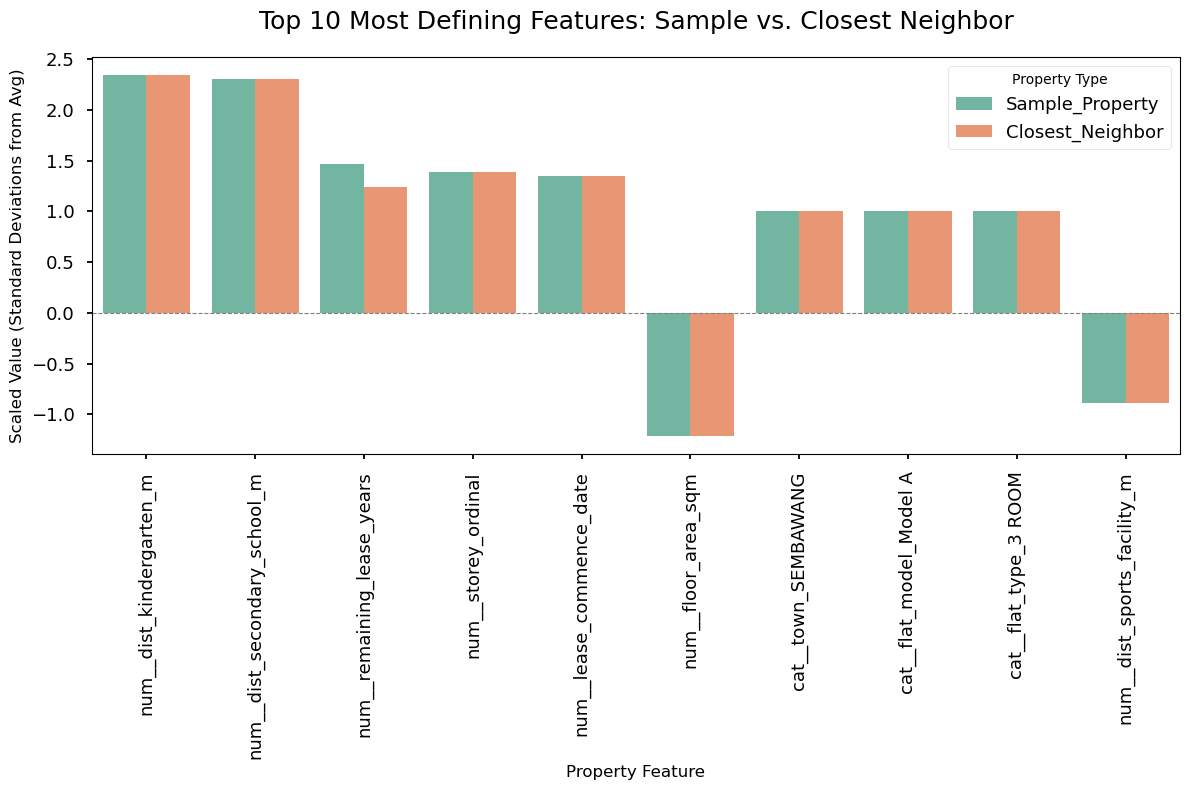

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- Bar Chart: Feature Comparison (AUTOMATICALLY SELECTING TOP FEATURES) ---

# Get all feature names
all_features = preprocessor.get_feature_names_out()

# Create a DataFrame with all features for the sample and its neighbor
comparison_df = pd.DataFrame({
    'Feature': all_features,
    'Sample_Property': sample_features_df[all_features].iloc[0].values,
    'Closest_Neighbor': neighbor_df[all_features].iloc[0].values
})

# 1. Calculate an 'importance' score
comparison_df['importance'] = comparison_df[['Sample_Property', 'Closest_Neighbor']].abs().max(axis=1)

# 2. Select the top N features based on this score
N = 10 
top_features_df = comparison_df.sort_values('importance', ascending=False).head(N)

# 3. Melt the DataFrame, specifying WHICH columns to melt
top_features_melted = top_features_df.melt(
    id_vars='Feature',
    value_vars=['Sample_Property', 'Closest_Neighbor'],
    var_name='Property',
    value_name='Scaled_Value'
)

# 4. Plotting only the top features
plt.style.use('seaborn-v0_8-talk')
fig, ax = plt.subplots(figsize=(12, 8))

# <-- 1. Changed the color palette for better contrast
sns.barplot(data=top_features_melted, x='Feature', y='Scaled_Value', hue='Property', ax=ax, palette="Set2") 

ax.set_title(f'Top {N} Most Defining Features: Sample vs. Closest Neighbor', fontsize=18, pad=20)
ax.set_xlabel('Property Feature', fontsize=12)
ax.set_ylabel('Scaled Value (Standard Deviations from Avg)', fontsize=12)
ax.axhline(0, color='grey', linestyle='--', linewidth=0.8)
plt.legend(title='Property Type')

# <-- 2. Changed rotation to 90 for vertical labels
plt.xticks(rotation=90) 

plt.tight_layout() # Adjusts plot to ensure everything fits without overlapping

# Save the figure for your slides
plt.savefig('feature_comparison_top10_vertical.png', dpi=300)
plt.show()

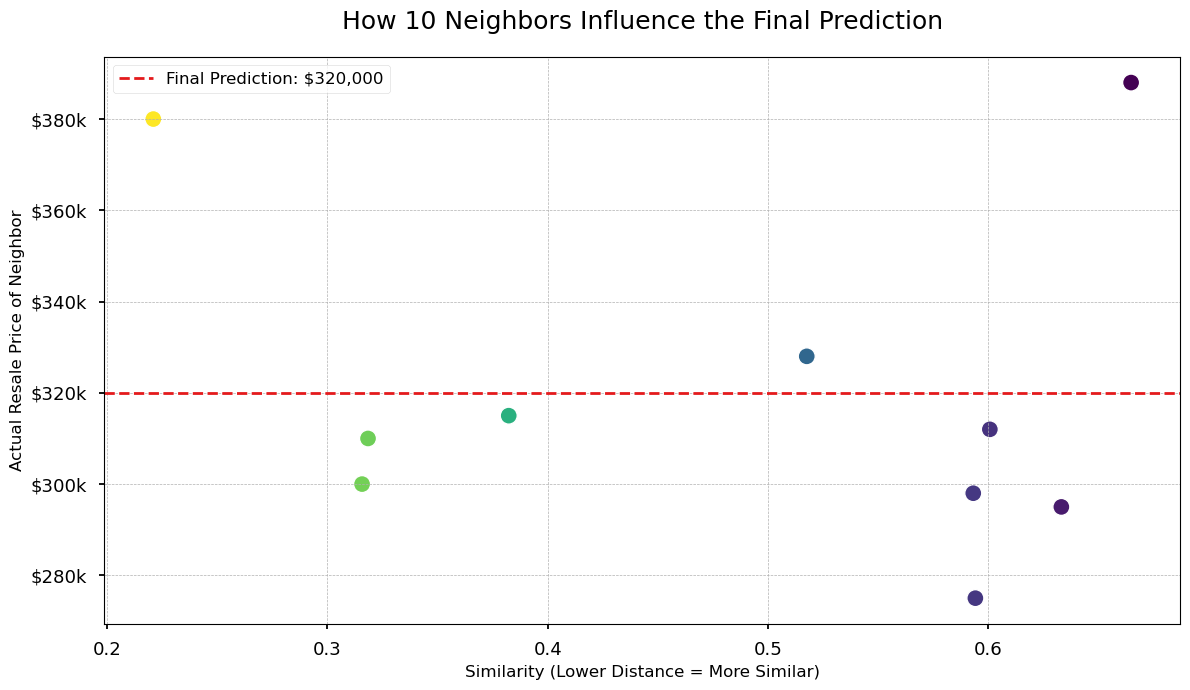

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Scatter Plot: Neighbors' Influence ---

# Ensure the DataFrame is sorted by distance (it should be already, but this is safe)
neighbor_df_sorted = neighbor_df.sort_values('distance_to_sample')

# --- Plotting ---
plt.style.use('seaborn-v0_8-talk')
fig, ax = plt.subplots(figsize=(12, 7))

# Create a color palette that varies with distance
palette = sns.light_palette("#79C", n_colors=len(neighbor_df_sorted), reverse=True)

# Plot each neighbor as a point
sns.scatterplot(
    x=neighbor_df_sorted['distance_to_sample'],
    y=neighbor_df_sorted['original_target_value'],
    s=150,  # size of the points
    hue=neighbor_df_sorted['distance_to_sample'], # color by distance
    palette='viridis_r', # Use a reversed color map so closer is brighter
    legend=False,
    ax=ax
)

# Add a horizontal line for the final prediction
ax.axhline(
    prediction_original,
    color='#e41a1c', # A distinct red color
    linestyle='--',
    linewidth=2,
    label=f'Final Prediction: ${prediction_original:,.0f}'
)

ax.set_title("How 10 Neighbors Influence the Final Prediction", fontsize=18, pad=20)
ax.set_xlabel("Similarity (Lower Distance = More Similar)", fontsize=12)
ax.set_ylabel("Actual Resale Price of Neighbor", fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Format y-axis to show dollar values
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'${int(x/1000)}k'))
plt.tight_layout()

# Save the figure for your slides
plt.savefig('neighbor_influence.png', dpi=300)
plt.show()

<h2>Multilayer Perceptron</h2>

Starting manual hyperparameter tuning...
Tuning Run 1/1
Parameters: {'hidden_layer_sizes': (512, 256), 'activation': 'relu', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'epochs': 30, 'batch_size': 64}
Test Loss (MSE): 0.0316, Test MAE: 0.1309
Time taken: 699.11 seconds
--------------------------------------------------
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
RMSE: 28679.820572970806

Sample Predictions (Original Scale):
   Actual Price  Predicted Price
0      292000.0     307999.75000
1      530000.0     540000.00000
2      345000.0     344161.87500
3      875000.0     876854.06250
4      298000.0     318212.84375


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │          36,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 505,349 (1.93 MB)

 Trainable params: 168,449 (658.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 336,900 (1.29 MB)

None


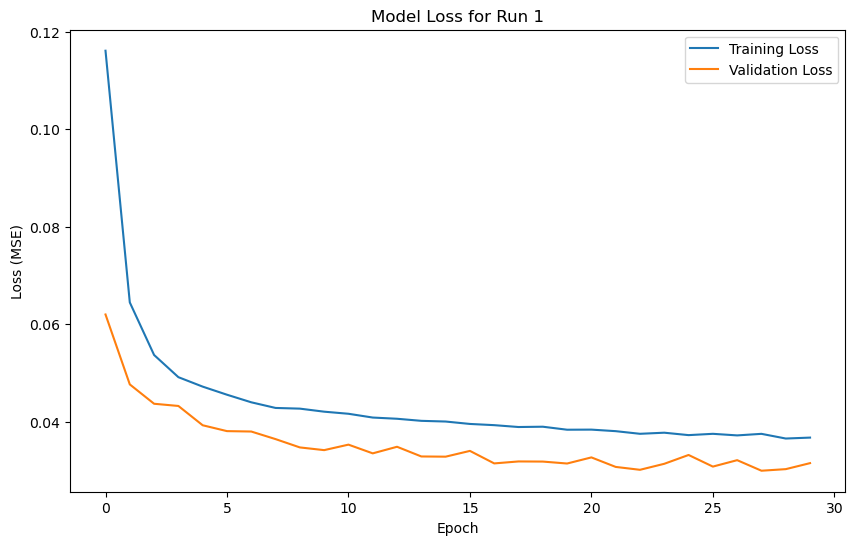

Manual tuning finished.

Best Hyperparameters found:
{'hidden_layer_sizes': (512, 256), 'activation': 'relu', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'epochs': 30, 'batch_size': 64}

Best Test Set MSE: 0.0316

Final Evaluation of Best Model on Test Set:
Test Set Mean Squared Error: 0.0316
Test Set Mean Absolute Error: 0.1309
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
RMSE: 28679.820572970806

Sample Predictions (Original Scale):
   Actual Price  Predicted Price
0      292000.0     307999.75000
1      530000.0     540000.00000
2      345000.0     344161.87500
3      875000.0     876854.06250
4      298000.0     318212.84375


In [6]:
def build_mlp(hidden_layer_sizes=(64,), activation='relu', optimizer_name='adam', learning_rate=0.001, dropout_rate=0.0):
    """Builds and compiles a Keras MLP model based on specified hyperparameters."""
    model = keras.Sequential()

    # Add hidden layers based on the tuple provided
    for units in hidden_layer_sizes:
        model.add(layers.Dense(units, activation=activation))
        if dropout_rate > 0:
            model.add(layers.Dropout(dropout_rate))

    # Output layer for regression
    model.add(layers.Dense(1, activation='linear'))

    # Select and configure the optimizer
    if optimizer_name.lower() == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name.lower() == 'rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

    # Compile the model
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    return model

hyperparameters_to_test = [
    {'hidden_layer_sizes': (512, 256), 'activation': 'relu', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'epochs': 30, 'batch_size': 64}
]

results = []
best_score = float('inf')
best_model = None
best_params = None

print("Starting manual hyperparameter tuning...")
print("==================================================")

for i, params in enumerate(hyperparameters_to_test):
    print(f"Tuning Run {i+1}/{len(hyperparameters_to_test)}")
    print(f"Parameters: {params}")
    start_time = time.time()

    # Build the model with the current set of hyperparameters
    model = build_mlp(
        hidden_layer_sizes=params['hidden_layer_sizes'],
        activation=params['activation'],
        learning_rate=params['learning_rate'],
        dropout_rate=params['dropout_rate']
    )

    # Train the model
    history = model.fit(
        X_train_processed,
        y_train_scaled,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        validation_split=0.2,  # Use a portion of training data for validation
        verbose=0#,  # Suppress lengthy output for each epoch
        # sample_weight=sample_weights,
    )

    # Evaluate the model on the test set
    score = model.evaluate(X_test_processed, y_test_scaled, verbose=0)
    end_time = time.time()

    print(f"Test Loss (MSE): {score[0]:.4f}, Test MAE: {score[1]:.4f}")
    print(f"Time taken: {end_time - start_time:.2f} seconds")
    print("--------------------------------------------------")

    results.append({'params': params, 'score': score[0]})

    # Check if this is the best model so far (based on MSE loss)
    if score[0] < best_score:
        best_score = score[0]
        best_model = model
        best_params = params

    # Make predictions with the model
    y_pred_scaled = model.predict(X_test_processed)
    y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
    rmse_mlp = np.sqrt(mean_squared_error(y_test, y_pred))
    # Display a few sample predictions vs actual values
    print(f"RMSE: {rmse_mlp}")
    print("\nSample Predictions (Original Scale):")
    predictions_df = pd.DataFrame({'Actual Price': y_test.values, 'Predicted Price': y_pred.flatten()})
    print(predictions_df.head())
    print("==================================================")

    print(model.summary())
    # Plot training & validation loss values
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model Loss for Run {i+1}')
    plt.ylabel('Loss (MSE)')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()


print("Manual tuning finished.")

# --- DISPLAY FINAL RESULTS ---
print("\n==================================================")
print("Best Hyperparameters found:")
print(best_params)
print(f"\nBest Test Set MSE: {best_score:.4f}")

# Evaluate the final best model again for clarity
test_loss, test_mae = best_model.evaluate(X_test_processed, y_test_scaled, verbose=0)
print("\nFinal Evaluation of Best Model on Test Set:")
print(f"Test Set Mean Squared Error: {test_loss:.4f}")
print(f"Test Set Mean Absolute Error: {test_mae:.4f}")

# Make predictions with the best model
y_pred_scaled = best_model.predict(X_test_processed)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
rmse_mlp = np.sqrt(mean_squared_error(y_test, y_pred))
# Display a few sample predictions vs actual values
print(f"RMSE: {rmse_mlp}")
print("\nSample Predictions (Original Scale):")
predictions_df = pd.DataFrame({'Actual Price': y_test.values, 'Predicted Price': y_pred.flatten()})
print(predictions_df.head())
print("==================================================")

In [31]:
import joblib
mlp = joblib.load('best_mlp.joblib')

C:\Users\Troyk\AppData\Local\Temp\ipykernel_9908\3212125569.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  indices = X_test.groupby(col).apply(
C:\Users\Troyk\AppData\Local\Temp\ipykernel_9908\3212125569.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  indices = X_test.groupby(col).apply(
C:\Users\Troyk\AppData\Local\Temp\ipykernel_9908\3212125569.py:21: DeprecationWarning: DataFrameGroupBy.apply 

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
--- Model Performance Report (RMSE) ---

----- RMSE by town -----
           town         RMSE
    BUKIT TIMAH 50963.221012
         BISHAN 50049.089135
   CENTRAL AREA 48690.192726
    BUKIT MERAH 44287.477223
  MARINE PARADE 44007.648102
     QUEENSTOWN 42492.451136
      TOA PAYOH 38897.242075
KALLANG/WHAMPOA 38436.271643
       CLEMENTI 35099.050118
      SERANGOON 35090.132598
     ANG MO KIO 34466.920648
       TAMPINES 34382.875587
        GEYLANG 34141.470374
          BEDOK 33723.929283
        HOUGANG 33490.224723
      PASIR RIS 32049.229256
    JURONG EAST 29394.513703
  BUKIT PANJANG 27473.421568
    BUKIT BATOK 27080.922104
      WOODLANDS 25630.349638
    JURONG WEST 25053.300956
        PUNGGOL 24756.368602
  CHOA CHU KANG 24118.888761
       SENGKANG 23918.467107
         YISHUN 22588.100137
      SEMBAWANG 21303.782296


----- RMSE by flat_type -----
       flat_type         RMSE
MULTI-GENERATION 57010.468638
       EXECUTIVE 4

C:\Users\Troyk\AppData\Local\Temp\ipykernel_9908\3212125569.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RMSE', y=col, data=data_to_plot, palette='viridis')


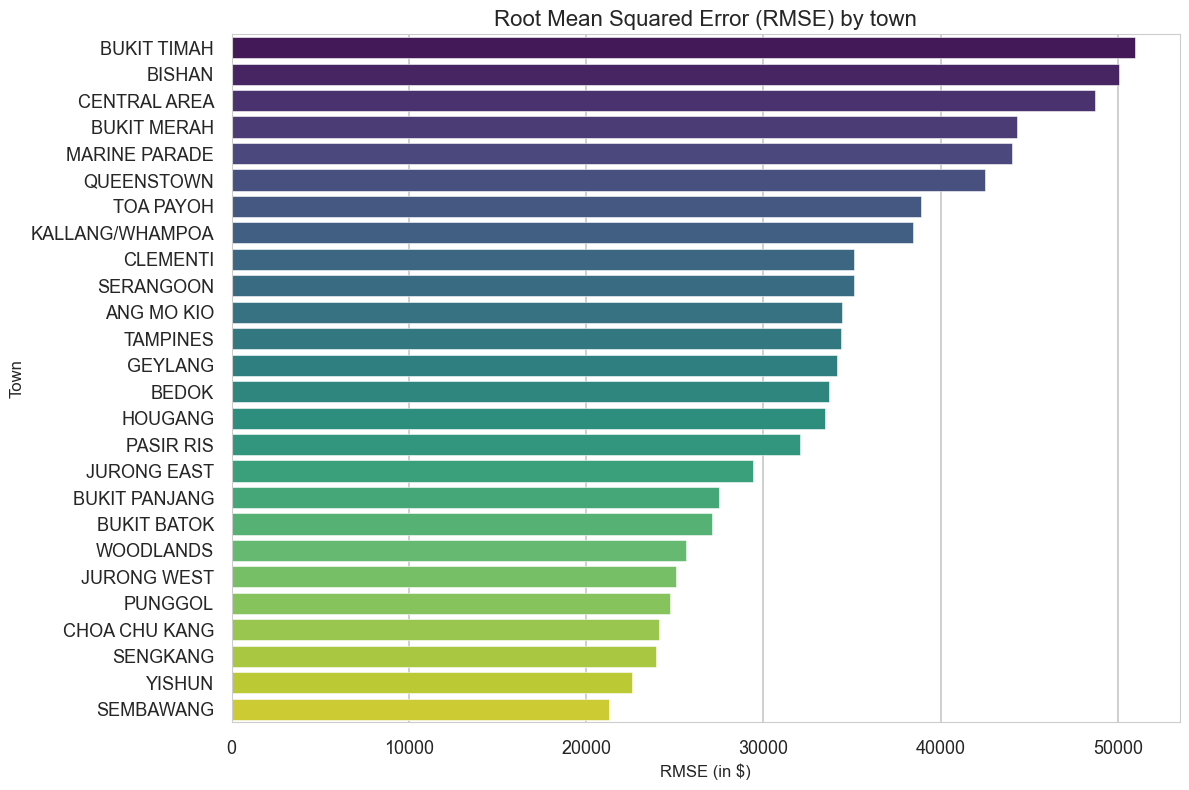

C:\Users\Troyk\AppData\Local\Temp\ipykernel_9908\3212125569.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='RMSE', data=data_to_plot, palette='viridis')


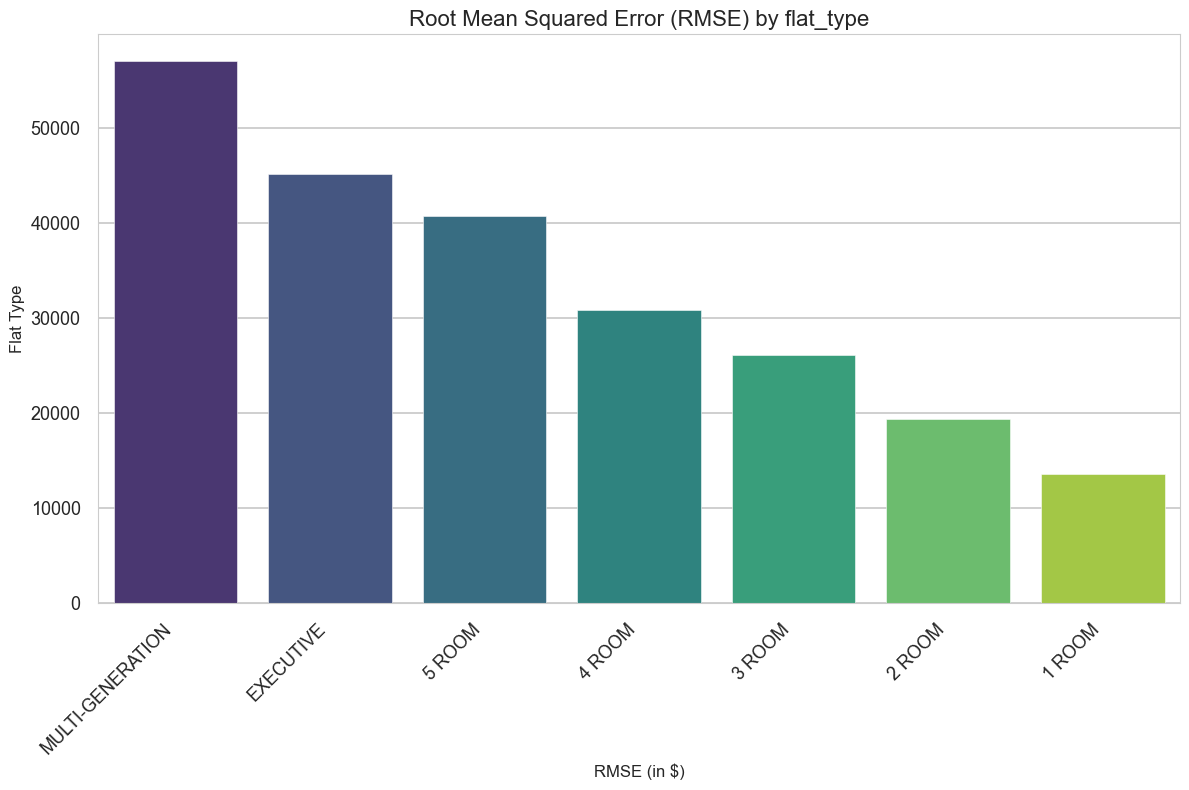

C:\Users\Troyk\AppData\Local\Temp\ipykernel_9908\3212125569.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RMSE', y=col, data=data_to_plot, palette='viridis')


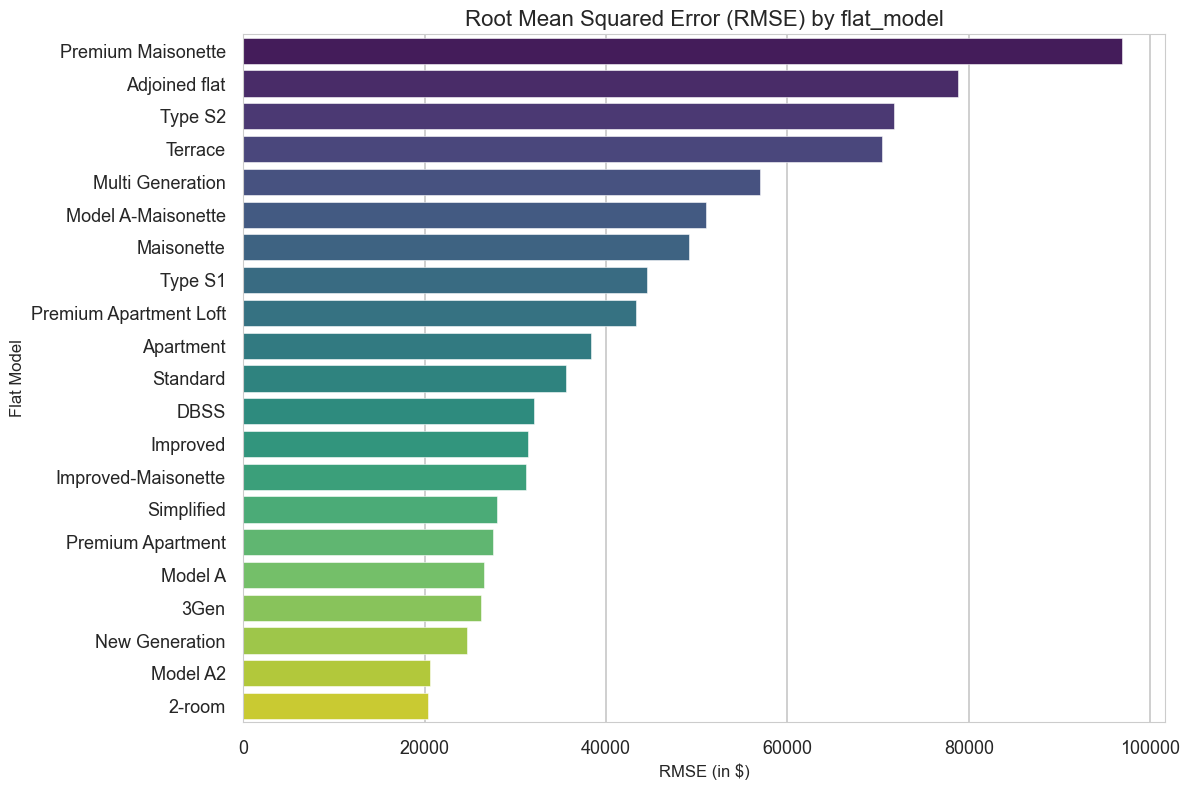

In [32]:
import pandas as pd
 
import numpy as np
 
import matplotlib.pyplot as plt
 
import seaborn as sns
 
from sklearn.metrics import mean_squared_error
 
# Columns to sample from
 
sampling_cols = ['town', 'flat_type', 'flat_model']
 
all_indices = []
 
# Group by each column and sample 100 from each group
 
for col in sampling_cols:
 
    indices = X_test.groupby(col).apply(
 
        lambda x: x.sample(n=min(len(x), 100), random_state=42)
 
    ).index.get_level_values(1) # Get the original index
 
    all_indices.extend(indices)
 
# Get a set of unique indices to avoid duplicates
 
unique_indices = sorted(list(set(all_indices)))
 
# Create the final report datasets using the unique indices
 
X_classification_report = X_test.loc[unique_indices]
 
y_classification_report = y_test.loc[unique_indices]
 
 
def generate_model_report(model, preprocessor, y_scaler, X_report, y_report):
 
    # 1. Preprocess the report data and make predictions
 
    X_report_processed = preprocessor.transform(X_report)
 
    y_pred_scaled = model.predict(X_report_processed)
 
    # 2. Inverse transform predictions to get actual prices
 
    y_pred_scaled = y_pred_scaled.reshape(-1, 1)
 
    y_pred = y_scaler.inverse_transform(y_pred_scaled).flatten()
 
    y_true = y_report.values
 
    # 3. Create a DataFrame for easy analysis
 
    results_df = X_report.copy()
 
    results_df['true_price'] = y_true
 
    results_df['predicted_price'] = y_pred
 
    results_df['squared_error'] = (results_df['true_price'] - results_df['predicted_price'])**2
 
    # Columns for which to generate reports
 
    report_cols = ['town', 'flat_type', 'flat_model']
 
    reports = {}
 
    print("--- Model Performance Report (RMSE) ---\n")
 
    # 4. Calculate RMSE for each class in each column
 
    for col in report_cols:
 
        rmse_by_class = results_df.groupby(col)['squared_error'].apply(lambda x: np.sqrt(x.mean()))
 
        report_df = rmse_by_class.reset_index(name='RMSE').sort_values('RMSE', ascending=False)
 
        reports[col] = report_df
 
        print(f"----- RMSE by {col} -----")
 
        print(report_df.to_string(index=False))
 
        print("\n" + "="*40 + "\n")
 
    # 5. Generate plots
 
    sns.set_style("whitegrid")
 
    for col in report_cols:
 
        plt.figure(figsize=(12, 8))
 
        # Sorting makes the chart easier to read
 
        data_to_plot = reports[col].sort_values('RMSE', ascending=False)
 
        # Adjust barplot orientation based on number of categories
 
        if len(data_to_plot) > 15:
 
            sns.barplot(x='RMSE', y=col, data=data_to_plot, palette='viridis')
 
        else:
 
            sns.barplot(x=col, y='RMSE', data=data_to_plot, palette='viridis')
 
            plt.xticks(rotation=45, ha='right')
 
        plt.title(f'Root Mean Squared Error (RMSE) by {col}', fontsize=16)
 
        plt.xlabel('RMSE (in $)', fontsize=12)
 
        plt.ylabel(col.replace('_', ' ').title(), fontsize=12)
 
        plt.tight_layout()
 
        plt.show()
 
# --- Call the function to generate the full report ---
 
generate_model_report(
 
    model=mlp,
 
    preprocessor=preprocessor,
 
    y_scaler=scaler,
 
    X_report=X_classification_report,
 
    y_report=y_classification_report
 
)

<h2>LSTM</h2>

Starting manual hyperparameter tuning for LSTM...
Tuning Run 1/1
Parameters: {'lstm_units': (512, 256, 128, 128), 'dense_layer_sizes': (), 'activation': 'relu', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'recurrent_dropout': 0.3, 'epochs': 100, 'batch_size': 64}


C:\Users\Troyk\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 16: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 27: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 32: ReduceLROnPlateau reducing learning rate to 1e-05.
Test Loss (MSE): 0.0379, Test MAE: 0.1457
Time taken: 6866.65 seconds
--------------------------------------------------
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step
RMSE: 32713.343376348257

Sample Predictions (Original Scale):
   Actual Price  Predicted Price
0      292000.0     305938.90625
1      530000.0     509049.18750
2      345000.0     340000.00000
3      875000.0     858605.00000
4      298000.0     350000.00000


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 512)              │       1,196,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 1, 256)              │         787,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 1, 128)              │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,936,965 (26.46 MB)

 Trainable params: 2,312,321 (8.82 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,624,644 (17.64 MB)

None


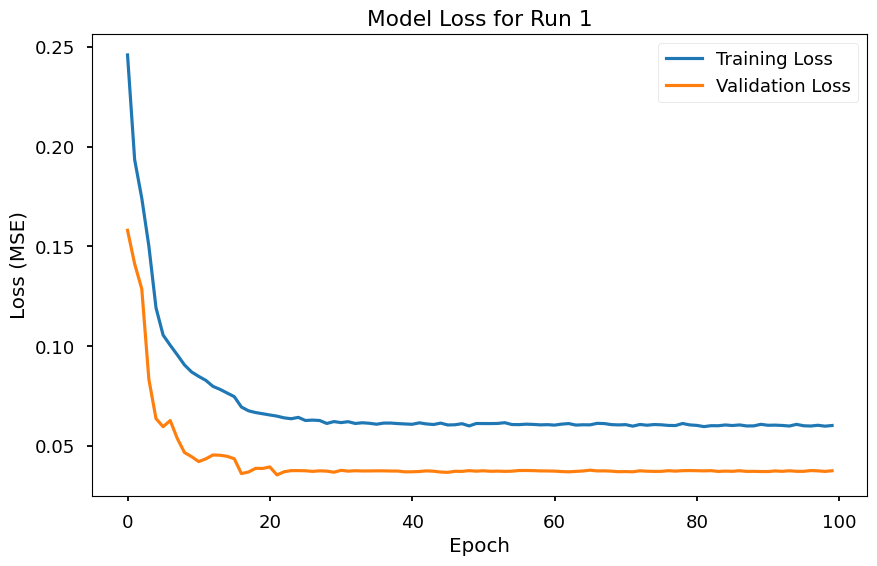

Manual tuning finished.

Best Hyperparameters found:
{'lstm_units': (512, 256, 128, 128), 'dense_layer_sizes': (), 'activation': 'relu', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'recurrent_dropout': 0.3, 'epochs': 100, 'batch_size': 64}

Best Test Set MSE (scaled): 0.0379

Final Evaluation of Best Model on Test Set (scaled):
Test Set Mean Squared Error: 0.0379
Test Set Mean Absolute Error: 0.1457
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step
RMSE: 32713.343376348257

Sample Predictions (Original Scale):
   Actual Price  Predicted Price
0      292000.0     305938.90625
1      530000.0     509049.18750
2      345000.0     340000.00000
3      875000.0     858605.00000
4      298000.0     350000.00000


In [28]:
X_train_reshaped = np.reshape(X_train_processed, (X_train_processed.shape[0], 1, X_train_processed.shape[1]))
X_test_reshaped = np.reshape(X_test_processed, (X_test_processed.shape[0], 1, X_test_processed.shape[1]))

# --- LSTM MODEL AND MANUAL HYPERPARAMETER SEARCH ---

def build_lstm(lstm_units=(64,), dense_layer_sizes=(), activation='relu', optimizer_name='adam', learning_rate=0.001, dropout_rate=0.0, recurrent_dropout=0.0):
    """Builds and compiles a Keras LSTM model based on specified hyperparameters."""
    model = keras.Sequential()

    # Add LSTM layers. For multiple LSTM layers, all but the last must have return_sequences=True.
    for i, units in enumerate(lstm_units):
        is_last_lstm = (i == len(lstm_units) - 1)
        model.add(layers.LSTM(
            units,
            return_sequences=not is_last_lstm,
            dropout=dropout_rate,
            recurrent_dropout=recurrent_dropout,
            input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]) # Only needed for the first layer
        ))

    # Add optional Dense layers after the LSTM block
    for units in dense_layer_sizes:
        model.add(layers.Dense(units, activation=activation))
        if dropout_rate > 0:
            model.add(layers.Dropout(dropout_rate))

    # Output layer for regression
    model.add(layers.Dense(1, activation='linear'))

    # Select and configure the optimizer
    if optimizer_name.lower() == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name.lower() == 'rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

    # Compile the model
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    return model

hyperparameters_to_test = [
    {'lstm_units': (512,256,128,128), 'dense_layer_sizes': (), 'activation': 'relu', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'recurrent_dropout': 0.3, 'epochs': 100, 'batch_size': 64}
]

results = []
best_score = float('inf')
best_model = None
best_params = None

print("Starting manual hyperparameter tuning for LSTM...")
print("==================================================")

for i, params in enumerate(hyperparameters_to_test):
    print(f"Tuning Run {i+1}/{len(hyperparameters_to_test)}")
    print(f"Parameters: {params}")
    start_time = time.time()

    # Build the model with the current set of hyperparameters
    model = build_lstm(
        lstm_units=params['lstm_units'],
        dense_layer_sizes=params['dense_layer_sizes'],
        activation=params['activation'],
        learning_rate=params['learning_rate'],
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout']
    )

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        verbose=1,
        min_lr=0.00001
    )
    
    # Train the model using the reshaped data
    history = model.fit(
        X_train_reshaped,
        y_train_scaled,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        validation_split=0.2,
        verbose=0,
        callbacks=[lr_scheduler]
    )

    # Evaluate the model on the reshaped test set
    score = model.evaluate(X_test_reshaped, y_test_scaled, verbose=0)
    end_time = time.time()

    print(f"Test Loss (MSE): {score[0]:.4f}, Test MAE: {score[1]:.4f}")
    print(f"Time taken: {end_time - start_time:.2f} seconds")
    print("--------------------------------------------------")

    results.append({'params': params, 'score': score[0]})

    # Check if this is the best model so far
    if score[0] < best_score:
        best_score = score[0]
        best_model = model
        best_params = params
    # Make predictions with the model
    y_pred_scaled = model.predict(X_test_reshaped)
    y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
    rmse_mlp = np.sqrt(mean_squared_error(y_test, y_pred))
    # Display a few sample predictions vs actual values
    print(f"RMSE: {rmse_mlp}")
    print("\nSample Predictions (Original Scale):")
    predictions_df = pd.DataFrame({'Actual Price': y_test.values, 'Predicted Price': y_pred.flatten()})
    print(predictions_df.head())
    print("==================================================")

    print(model.summary())
    # Plot training & validation loss values
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model Loss for Run {i+1}')
    plt.ylabel('Loss (MSE)')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print("Manual tuning finished.")

# --- DISPLAY FINAL RESULTS ---
print("\n==================================================")
print("Best Hyperparameters found:")
print(best_params)
print(f"\nBest Test Set MSE (scaled): {best_score:.4f}")

# Evaluate the final best model again for clarity
test_loss, test_mae = best_model.evaluate(X_test_reshaped, y_test_scaled, verbose=0)
print("\nFinal Evaluation of Best Model on Test Set (scaled):")
print(f"Test Set Mean Squared Error: {test_loss:.4f}")
print(f"Test Set Mean Absolute Error: {test_mae:.4f}")

# Make predictions with the best model using the reshaped data
y_pred_scaled = best_model.predict(X_test_reshaped)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

# Calculate MSE on the original price scale
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse_lstm}")

# Display a few sample predictions vs actual values
print("\nSample Predictions (Original Scale):")
predictions_df = pd.DataFrame({'Actual Price': y_test.values, 'Predicted Price': y_pred.flatten()})
print(predictions_df.head())
print("==================================================")